In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

# Estimate fields
- ground_truth/beam_search_lb
- Importance sampling estimate
- Hybrid estimate
- Importance sampling variance
- Hybrid variance

# General Metadata
- dataset_name
- experiment_name
- history_id
- Excluded term
- sequence_length
- history_length
- total_sequence_length

# Sampling metadata
- num_mc_samples (sub_estimates)
- sample_model_iters

# Hybrid data
- hybrid_model_iters

# Beam search metadata
- min_variance
- search_model_iters
- min_variance_reduction
- true_coverage
- restricted_coverage
- num_beams
- top_k
- top_p
- (beam search) interpolation_func


In [34]:
def get_experiment_data(experiment, dataset, h, s, root="../data", 
            methods=['beam_search_is_hybrid','importance_sampling','random_sampling','beam_search'],
            gt_methods=['ground_truth','beam_search']):
    
        data_dict = {}
        gt_type=None
        for method in methods:
            template_path=root + f"/{method}/{dataset}/{experiment}/"
            template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
            f"{method.replace('_','-')}_{h}h_{s}s*mc.pkl")
            pot_pattern = os.path.join(template_path,template_file)
            pot_paths = glob.glob(pot_pattern)
            assert len(pot_paths) == 1,\
                f"Found {len(pot_paths)} paths for {pot_pattern}"
            print(method, pot_paths[0])
            data_dict[method]= read_pkl(pot_paths[0])
            data_dict[method]['metadata']['result_filepath'] = pot_paths[0]
        for gt_method in gt_methods:
            try:
                template_path=root + f"/{gt_method}/{dataset}/{experiment}/"
                # Don't match on model budget terms
                template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
                               f"{gt_method.replace('_','-')}_{h}h_{s}s*[!t].pkl")
                pot_pattern = os.path.join(template_path,template_file)
                pot_paths = glob.glob(pot_pattern)
                assert len(pot_paths) == 1,\
                    f"Found {len(pot_paths)} paths for {pot_pattern}"
                print("GT: ", gt_method, "\n",pot_paths[0],"\n=============")
                data_dict[gt_method]= read_pkl(pot_paths[0])
                data_dict[gt_method]['metadata']['result_filepath'] = pot_paths[0]
                data_dict['gt_type'] = gt_method
                return data_dict
            except: pass
        assert False,"Could not find ground truth"
        print()
        return None
    
def get_experiment_data_model_budget(experiment, dataset, h, s, root="../data", 
            methods=['beam_search_is_hybrid','importance_sampling','random_sampling','beam_search'],
            gt_methods=['ground_truth','beam_search']):
    
        data_dict = {}
        gt_type=None
        for method in methods:
            template_path=root + f"/{method}/{dataset}/{experiment}/"
            template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_"
            + f"{method.replace('_','-')}_{h}h_{s}s*{'' if method == 'beam_search_is_hybrid' else 'model-budget'}.pkl")
            pot_pattern = os.path.join(template_path,template_file)
            pot_paths = glob.glob(pot_pattern)
            assert len(pot_paths) == 1,\
                f"Found {len(pot_paths)} paths for {pot_pattern}"
            # print(method,pot_paths[0])
            print(method, "\n",pot_paths[0],"\n=============")
            data_dict[method]= read_pkl(pot_paths[0])
            data_dict[method]['metadata']['result_filepath'] = pot_paths[0]
        for gt_method in gt_methods:
            try:
                template_path=root + f"/{gt_method}/{dataset}/{experiment}/"
                template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
                               f"{gt_method.replace('_','-')}_{h}h_{s}s*.pkl")
                pot_pattern = os.path.join(template_path,template_file)
                pot_paths = glob.glob(pot_pattern)
                assert len(pot_paths) == 1,\
                    f"Found {len(pot_paths)} paths for {pot_pattern}"
                print("GT: ", gt_method, "\n",pot_paths[0],"\n=============")
                data_dict[gt_method]= read_pkl(pot_paths[0])
                data_dict[gt_method]['metadata']['result_filepath'] = pot_paths[0]
                data_dict['gt_type'] = gt_method
                return data_dict
            except: pass
        assert False,"Could not find ground truth"
        return None
                

In [55]:
def flatten_sampling(samp_dict,sub_estimates,sample_type="importance"):
    samp_estimates = samp_dict['sample_estimates'][:,:len(sub_estimates)]
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            assert samp_estimates.shape[1] == samp_dict['metadata']['num_mc_samples'],\
            (f"Error, estimate dimensions are {samp_estimates.shape} but the number of samples is " +
             f"{samp_dict['metadata']['num_mc_samples']}, which does not match")
            
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of imp_samp_estimates is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df.insert(0,'num_mc_samples',samp_dict['metadata']['num_mc_samples'])
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
        df[f'{sample_type}_est_variance'] = samp_dist['sample_estimate_var']
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            samp_var = pd.DataFrame(samp_dict['sample_estimate_var'][:,:len(sub_estimates)],columns=sub_estimates)
            model_iters_df = pd.DataFrame(samp_dict['model_iters'][:,:len(sub_estimates)],columns=sub_estimates)
            df = pd.melt(samp_estimates,value_vars=sub_estimates)
            df.columns = ['num_samples','sample_estimate']
            var_df =  pd.melt(samp_var,value_vars=sub_estimates)
            var_df.columns = ['num_samples','variance']
            iter_df = pd.melt(model_iters_df,value_vars=sub_estimates)
            iter_df.columns = ['num_samples','model_iters']
            df[f'{sample_type}_model_iters']=iter_df['model_iters']
            df[f'{sample_type}_est_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                df = pd.DataFrame(
                            torch.gather(samp_estimates[:,i],1,
                                      samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                        )
                df.insert(0,'num_mc_samples',sub_estimates[i])
                df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:,i]
                print(samp_dict['sample_estimate_var'].shape)
                samp_est_var = torch.gather(samp_dict['sample_estimate_var'][:,i],1,
                                            samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                                            
                df[f'{sample_type}_est_variance'] = samp_est_var
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    assert df.shape[-1] == 4, f"DF shape is {df.shape}"
    df.columns = ['num_mc_samples',f'{sample_type}_sampling_est',
                  f'{sample_type}_model_iters',f'{sample_type}_est_variance']
    
    return df



def flatten_gt(data_dict,gt_type):
    gt_dict = data_dict[gt_type]
    # gt = gt_dict['bs_lower_bound']
    gt = torch.gather(gt_dict['bs_lower_bound'],1,
                      gt_dict['excluded_terms'].unsqueeze(-1)).squeeze()
    assert len(gt.shape) == 1,\
    f"Ground truth has {len(gt.shape)} dimensions"
    df = pd.DataFrame(gt,columns=['ground_truth'])
    for item in ['true_coverage','restricted_coverage']:
        df[item] = [gti.item() for gti in gt_dict[item]]
    # df["gt_model_iters"] = gt_dict['model_iters']
    df['gt_type'] = gt_type
    
    return df
    

def flatten_experiment(data_dict,experiment, dataset,h,s,
     global_agreement_vals= ['excluded_terms']):
    sub_estimates = sorted(list(
        # set(data_dict['importance_sampling']['metadata']['sub_estimates']) &
        # set(data_dict['random_sampling']['metadata']['sub_estimates']) &
        set(data_dict['beam_search_is_hybrid']['metadata']['sub_estimates'])))
    sub_est_len = 1 if not sub_estimates else len(sub_estimates)
    importance_df = flatten_sampling(data_dict['importance_sampling'],sub_estimates,sample_type ='importance')
    random_df = flatten_sampling(data_dict['random_sampling'],sub_estimates,sample_type ='random')
    hybrid_df = flatten_sampling(data_dict['beam_search_is_hybrid'],sub_estimates,sample_type ='hybrid')
    hybrid_df.drop("num_mc_samples",inplace = True,axis=1)
    
    gt_df = flatten_gt(data_dict,data_dict['gt_type'])
    gt_df = pd.concat([gt_df]*sub_est_len,axis=0,ignore_index=True)
    final_df = pd.concat([importance_df,hybrid_df,gt_df],axis=1)
    
    # Metadata checks
    is_metadata = ['top_k','top_p']
    bs_metadata = ['min_variance','min_var_reduction','num_beams']
    for m in is_metadata:
        final_df[m] = data_dict['importance_sampling']['metadata'][m]
    for m in bs_metadata:
        final_df[m] = data_dict[data_dict['gt_type']]['metadata'][m]
    final_df['interp_func'] = str(data_dict[data_dict['gt_type']]['metadata']['interp_func']).split(" ")[1]
    
    
    final_df['dataset_name'] = dataset
    final_df['hist_len'] = h
    final_df['total_seq_len'] = s
    final_df['seq_len'] = s-h
    sequence_ids = list(range(data_dict['importance_sampling']['sample_estimates'].shape[0]))*sub_est_len
    excluded_terms = data_dict['importance_sampling']['excluded_terms'].numpy().tolist()*sub_est_len
    final_df['sequence_id'] = sequence_ids
    final_df['excluded_term'] = excluded_terms
    phase_shifts = read_pkl("/srv/disk00/samshow/amazon/amazon_phase_trans.pkl")
    phase_shift_val_inds = read_pkl("../data/amazon/amazon_val_dl_transition_inds.pkl")
    phase_shifts = phase_shifts[phase_shift_val_inds].numpy().tolist()
    # print(phase_shift_val_inds.shape, final_df.shape)
    # final_df['phase_shifts'] = phase_shifts * sub_est_len
    # final_df['phase_shifts'] -=1
    
    return final_df
     
    
    

In [56]:
experiment = ["val_dl"]
dataset = ["apps"]
lengths = [(13,15),(12,15)]
def flatten_experiments(experiments, datasets, lengths,model_budget=False):
    data_list = []
    for experiment in experiments:
        for dataset in datasets:
            for h,s in lengths:
                # try:
                    
                    if model_budget:
                        data = get_experiment_data(experiment,dataset,h,s)
                    else:
                        data = get_experiment_data_model_budget(experiment,dataset,h,s)
                        
                    df = flatten_experiment(data,experiment, dataset, h,s)
                    
                    # print(df.head())
                    # print(df.columns)
                    # print(df.shape)
                    # sys.exit(1)
                    
                    data_list.append(df)
                    
    # print(len(data_list))
    data_df = pd.concat(data_list,axis = 0)
    ordering = [ 'dataset_name','sequence_id','seq_len', 'excluded_term', 'gt_type','ground_truth','importance_sampling_est','hybrid_sampling_est', 
                'num_mc_samples', 'importance_model_iters','hybrid_model_iters',
       'importance_est_variance',  'hybrid_est_variance',
         'true_coverage', 'restricted_coverage',  'top_k', 'top_p', 'min_variance',
       'min_var_reduction', 'num_beams', 'interp_func',
       'hist_len', 'total_seq_len']#, 'phase_shifts']
    data_df = data_df[ordering]
    print(data_df.columns)
    
    return data_df
                
                          

In [57]:
df = flatten_experiments(['val_dl'],['shakespeare'],[(18,20),(17,20)])
# df = flatten_experiments(['val_dl'],['shakespeare'],[(18,20)])

beam_search_is_hybrid 
 ../data/beam_search_is_hybrid/shakespeare/val_dl/val-dl_shakespeare_beam-search-is-hybrid_18h_20s_1000mc.pkl 
importance_sampling 
 ../data/importance_sampling/shakespeare/val_dl/val-dl_shakespeare_importance-sampling_18h_20s_1000mc_model-budget.pkl 
random_sampling 
 ../data/random_sampling/shakespeare/val_dl/val-dl_shakespeare_random-sampling_18h_20s_1000mc_model-budget.pkl 
beam_search 
 ../data/beam_search/shakespeare/val_dl/val-dl_shakespeare_beam-search_18h_20s_model-budget.pkl 
GT:  ground_truth 
 ../data/ground_truth/shakespeare/val_dl/val-dl_shakespeare_ground-truth_18h_20s.pkl 
torch.Size([6861, 68])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [32]:
# data['importance_sampling']['metadata']['sub_estimates']
# print(df.shape)
# print(df.isnull().sum())
# df.phase_shifts.describe()
# df[['importance_model_iters','hybrid_model_iters']].tail(50)

,importance_model_iters,hybrid_model_iters
6811,3000,2304
6812,3000,2936
6813,3000,2803
6814,3000,2923
6815,3000,2290
6816,3000,2638
6817,3000,2002
6818,3000,2661
6819,3000,2553
6820,3000,2856


In [31]:
df.head()

,dataset_name,sequence_id,seq_len,excluded_term,gt_type,ground_truth,importance_sampling_est,hybrid_sampling_est,num_mc_samples,importance_model_iters,...,true_coverage,restricted_coverage,top_k,top_p,min_variance,min_var_reduction,num_beams,interp_func,hist_len,total_seq_len
0,shakespeare,0,2,42,ground_truth,0.067603,0.046714,0.087690,10,20,...,0.944602,1.0,0,0,False,0.9,1.0,lin_interp,18,20
1,shakespeare,1,2,1,ground_truth,0.201895,0.221774,0.177074,10,20,...,0.865448,1.0,0,0,False,0.9,1.0,lin_interp,18,20
2,shakespeare,2,2,32,ground_truth,0.063420,0.063707,0.063389,10,20,...,0.999394,1.0,0,0,False,0.9,1.0,lin_interp,18,20
3,shakespeare,3,2,20,ground_truth,0.866673,0.799308,0.868733,10,20,...,0.999972,1.0,0,0,False,0.9,1.0,lin_interp,18,20
4,shakespeare,4,2,46,ground_truth,0.154992,0.296705,0.161840,10,20,...,0.883579,1.0,0,0,False,0.9,1.0,lin_interp,18,20


Text(0.5, 1.0, 'importance')

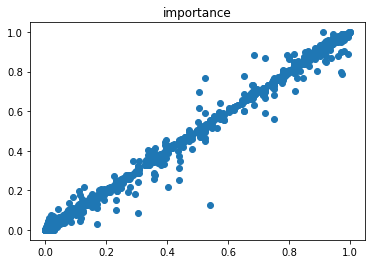

In [26]:
# df = df[df['phase_shifts'] > 10]
plt.scatter(df['ground_truth'],df['importance_sampling_est'])
plt.title("importance")

In [27]:
df[['importance_est_variance','hybrid_est_variance']].describe()

,importance_est_variance,hybrid_est_variance
count,2.191800e+04,2.191800e+04
mean,3.688037e-05,3.907905e-06
std,6.492985e-04,8.797111e-05
min,2.860333e-20,1.116206e-19
25%,4.422974e-09,1.191007e-09
50%,4.011587e-08,1.700204e-08
75%,3.072154e-07,1.139661e-07
max,4.445925e-02,4.038442e-03


In [28]:
df.isnull().sum()

dataset_name               0
sequence_id                0
seq_len                    0
excluded_term              0
gt_type                    0
ground_truth               0
importance_sampling_est    0
hybrid_sampling_est        0
num_mc_samples             0
importance_model_iters     0
hybrid_model_iters         0
importance_est_variance    0
hybrid_est_variance        0
true_coverage              0
restricted_coverage        0
top_k                      0
top_p                      0
min_variance               0
min_var_reduction          0
num_beams                  0
interp_func                0
hist_len                   0
total_seq_len              0
dtype: int64

In [33]:
df.to_csv('shakespeare_17-18_20.csv',index=None)
# df.to_csv('amazon_12-13_15_with-phase.csv',index=None)
# df.to_csv('apps_12-13_15.csv',index=None)

In [100]:
amazon_dict = read_pkl("/srv/disk00/samshow/amazon/amazon_text_dict.pkl")

In [101]:
data = amazon_dict['text']

In [102]:
data.shape

torch.Size([63844580, 16])

In [109]:
data[0]

tensor([ 0., 16., 16., 16., 11.,  3., 27., 27.,  9.,  9.,  9., 23., 16., 16.,
        16.,  8.])

In [112]:
from tqdm import tqdm
trans = []
for i in tqdm(range(data.shape[0])):
    trans.append(torch.unique_consecutive(data[i,1:]).shape)
    

100%|██████████| 63844580/63844580 [17:23<00:00, 61164.82it/s]  


In [125]:
trans = torch.LongTensor(trans).flatten()

In [126]:
trans.shape

torch.Size([63844580])

In [127]:
write_pkl(trans, "/srv/disask00/samshow/amazon/amazon_phase_trans.pkl")

In [121]:
trans_vals = []
for i in range(1,trans.max()+1):
    trans_vals.append((trans == i).sum().item()/trans.shape[0])

In [123]:
amazon_perc_per_phase_shift = [0.059163910233257073,
 0.020707521296247856,
 0.056485656260876024,
 0.04778584180520884,
 0.07297364944682853,
 0.07653857226408256,
 0.09382401763783238,
 0.10168632952084578,
 0.1102257544806466,
 0.10986890351538063,
 0.09992870185691566,
 0.0774158276238954,
 0.047934671979986396,
 0.020711280425057224,
 0.004749361652939059]